# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [15]:
import numpy as np

In [16]:
class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None
        
        # 每个结点需要保存梯度
        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''
        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented

In [17]:
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
               
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N

In [18]:
# 基本用不到，作用是直接的sum求和
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

In [19]:
class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

In [20]:
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

In [21]:
class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff



In [22]:
def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in graph[::-1]:
        n.backward()

In [23]:
# 拓扑排序，确保所有点都已经执行完毕
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [24]:
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [25]:
from sklearn.datasets import load_boston

In [26]:
data = load_boston()

In [27]:
data['data']

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [28]:
data['target']

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [29]:
losses = []

In [30]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
# x_:输入数据， y_:标签数据
X_ = data['data']
y_ = data['target']
"""
np.mean(X_, axis=0):
计算X_,列的均值
np.std(X_, axis=0):
计算每一列的标准差
"""
# Normalize data 标准化数据
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
# n_features = X_.shape[1]: 第一维的长度
n_features = X_.shape[1]
n_hidden = 10
"""
numpy.random.randn(d0,d1,…,dn)
randn函数返回一个或一组样本，具有标准正态分布。
dn表格每个维度
返回值为指定维度的array
"""
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1) # wT*x+b 
s1 = Sigmoid(l1)
print("s1", s1)
l2 = Linear(s1, W2, b2) # WTS1+b
cost = MSE(y, l2) #l2:预测值，y:真实值

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16 
steps_per_epoch = m // batch_size

# 拓扑排序，按照入度为0的先算
graph = topological_sort(feed_dict)
print("graph", graph)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples 随机取一些样本
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

s1 <__main__.Sigmoid object at 0x1a3c2eb9e8>
graph [<__main__.Input object at 0x1a3c2eb898>, <__main__.Input object at 0x1a3c2eb8d0>, <__main__.Input object at 0x1a3c2eb908>, <__main__.Input object at 0x1a3c297b38>, <__main__.Input object at 0x1a3c29f748>, <__main__.Input object at 0x1a3c2eb160>, <__main__.Linear object at 0x1a3c2eb978>, <__main__.Sigmoid object at 0x1a3c2eb9e8>, <__main__.Linear object at 0x1a3c2eb9b0>, <__main__.MSE object at 0x1a3c2eba20>]
Total number of examples = 506
Epoch: 1, Loss: 202.206
Epoch: 101, Loss: 6.912
Epoch: 201, Loss: 6.419
Epoch: 301, Loss: 5.336
Epoch: 401, Loss: 4.507
Epoch: 501, Loss: 4.387
Epoch: 601, Loss: 4.736
Epoch: 701, Loss: 3.779
Epoch: 801, Loss: 4.325
Epoch: 901, Loss: 4.441
Epoch: 1001, Loss: 3.879
Epoch: 1101, Loss: 3.982
Epoch: 1201, Loss: 3.981
Epoch: 1301, Loss: 4.297
Epoch: 1401, Loss: 3.789
Epoch: 1501, Loss: 4.060
Epoch: 1601, Loss: 3.475
Epoch: 1701, Loss: 3.576
Epoch: 1801, Loss: 3.927
Epoch: 1901, Loss: 4.146
Epoch: 2001, Lo

In [32]:
# 重写一个单独的forward，进行预测
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [33]:
forward(l2, graph)

array([[19.91343784],
       [28.15001676],
       [27.16642841],
       [24.03900084],
       [13.72681785],
       [34.96495762],
       [14.44105743],
       [12.45257139],
       [17.9394075 ],
       [51.82792265],
       [13.77552878],
       [14.16392985],
       [28.15001676],
       [16.37014317],
       [23.06338332],
       [18.43910766]])

In [34]:
import matplotlib.pyplot as plt

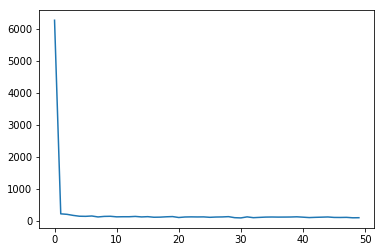

In [35]:
plt.plot(range(len(losses)), losses)

In [36]:
W2.value

array([[ 6.13222947],
       [ 6.62729148],
       [10.88142172],
       [ 7.03981609],
       [ 9.49238229],
       [ 7.85870925],
       [ 5.17713806],
       [ 5.20505656],
       [ 9.03105159],
       [11.07377852]])

In [37]:
x_ = data['data']

In [38]:
x_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [87]:
!pip install keras

    100% |████████████████████████████████| 378kB 4.2kB/s ta 0:00:02


In [39]:
import keras

In [40]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
             optimizer='sgd',
             metrics=['mse'])

In [ ]:
model.fit(x_, y_, epochs=500, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500


### 2. 回答一下理论题目

#### 1. What does a neuron compute?

- 实质上是各种矩阵变换操作
- 给定输入数据，根据预先定义的模型架构，函数等，通过反向传播不断更新参数值

####  2. Why we use non-linear activation funcitons in neural networks?

- 如果使用线性函数，经过矩阵操作后，得出的，还会是一个线性的结果，体现不出隐藏层的作用，也无法学习和模拟复杂的现实中的一些问题

#### 3. What is the 'Logistic Loss' ?

$$ g(z) = \frac{1}{1+e^{-z}} $$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

- 答案：A C
- 理由：因为问题是一个二分类问题，A C两个激活函数的范围都是（0，1）

#### 5. Why we don't use zero initialization for all parameters ?

- 如果使用0进行初始化，最终结果也是0

#### 6. Can you implement the softmax function using python ? 

$$ softmax(x_i) = \frac{exp(x_i)}{\sum_i{exp(x_i)}} $$

In [5]:
import numpy as np

# axis=0, 普通的相加
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=0)


In [6]:
softmax([3.0, 1.0, 0.2])

array([0.8360188 , 0.11314284, 0.05083836])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [49]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - each image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [50]:
# Loading the data 
digits = datasets.load_digits()

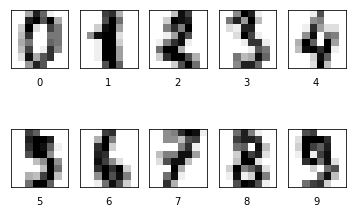

In [51]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [52]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [53]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [54]:
X_train

array([[ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  9., ...,  7.,  0.,  0.],
       [ 0.,  0.,  6., ...,  1.,  0.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16., 12.,  1.]])

In [55]:
X_train[0]

array([ 0.,  0.,  3., 15., 16., 15.,  1.,  0.,  0.,  0.,  9., 11.,  9.,
       16.,  3.,  0.,  0.,  0.,  1.,  0.,  3., 16.,  3.,  0.,  0.,  0.,
        0.,  0.,  9., 14.,  0.,  0.,  0.,  0.,  4., 15., 15., 16.,  6.,
        0.,  0.,  0.,  2., 12., 15.,  7.,  1.,  0.,  0.,  0.,  0., 13.,
        8.,  0.,  0.,  0.,  0.,  0.,  4., 14.,  1.,  0.,  0.,  0.])

In [56]:
X_train[1]

array([ 0.,  0.,  9., 13.,  6.,  0.,  0.,  0.,  0.,  0., 14.,  7., 11.,
        3.,  0.,  0.,  0.,  4.,  7.,  8.,  5.,  8.,  0.,  0.,  0.,  8.,
       10., 15., 14.,  9.,  0.,  0.,  0.,  0.,  4.,  7.,  9., 13.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  5., 11.,  0.,  0.,  0.,  2.,  0.,
        2., 12.,  6.,  0.,  0.,  0., 10., 14., 14.,  7.,  0.,  0.])

In [58]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

In [59]:
y_train.T

array([1, 1, 1, ..., 0, 0, 1])

In [61]:
(y_train.T).shape

(1347,)

In [71]:
y_train.reshape(-1, 1).shape

(1347, 1)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

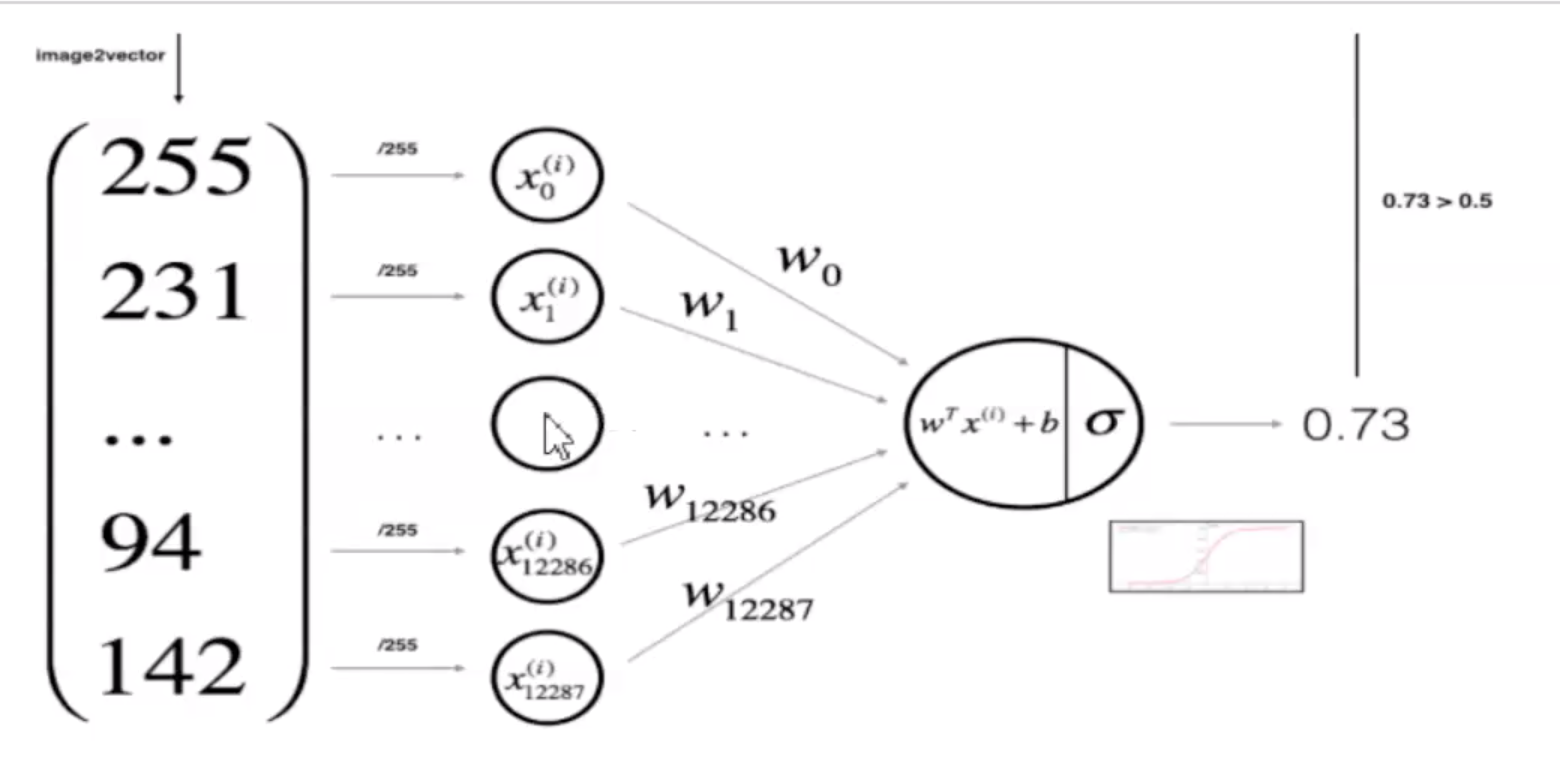

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [10]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1. / (1 + np.exp(-1 * z))
    
    return s

In [11]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [43]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim, 1)
    b = 0.0
#     print(b)
    # assert作用:用于判断一个表达式，在表达式条件为 false 的时候触发异常
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [44]:
initialize_parameters(10)

(array([[-4.28001937e-01],
        [-9.75320352e-01],
        [ 9.53242716e-01],
        [ 2.66809327e-01],
        [-1.97303168e+00],
        [-1.37778426e+00],
        [ 1.30933673e-03],
        [-3.77133610e-01],
        [-9.03441828e-01],
        [-1.32003570e-01]]), 0.0)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [45]:
np.dot([1, 2], [[1], [2]])

array([5])

In [131]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
#     X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    X = np.nan_to_num(X / X.max(axis=0))
#     print("X", X)
    m = X.shape[1] # 列数
    A = sigmoid(np.dot(X, w) + b)
#     print("A.shape", A.shape) # A.shape (1347, 1)
#     print("A", A)
#     print(Y.T.shape) # (1, 1347)
#     cost = (-1 / m)* np.dot(np.nan_to_num(Y*np.log(A))+(1-Y)*np.log(1-A)) 
    cost = (-1.0 / m)* (np.dot(Y.T, np.log(A)) + np.dot(1-Y.T, np.log(1-A)))
#     print("cost", cost)
    
    dw = (1.0/m)*np.dot(X.T, (A-Y))
    db = (1.0/m)*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    # 利用squeeze（）函数将表示向量的数组转换为秩为1的数组
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [132]:
w, b = initialize_parameters(64)

In [133]:
propagate(w,b, X_train, y_train.reshape(-1, 1))

/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


({'dw': array([[ 0.00000000e+00],
         [ 1.14514469e-01],
         [ 7.67677428e-01],
         [ 2.93727153e+00],
         [ 2.18499742e+00],
         [-6.55874381e-01],
         [-6.07987512e-01],
         [-6.31133868e-02],
         [ 9.74071554e-03],
         [ 3.67611103e-01],
         [ 1.58477613e+00],
         [ 3.45921728e+00],
         [ 3.29737645e+00],
         [ 1.38501857e+00],
         [-2.57147799e-01],
         [-7.09490052e-02],
         [ 1.34352626e-02],
         [ 3.41203889e-01],
         [ 1.65673922e+00],
         [ 2.24278403e+00],
         [ 2.42984876e+00],
         [ 2.04438459e+00],
         [ 3.86209291e-01],
         [-4.21620743e-03],
         [ 1.34104119e-02],
         [ 6.19703999e-01],
         [ 1.61817160e+00],
         [ 6.42343461e-01],
         [ 1.16538534e+00],
         [ 1.17013956e+00],
         [ 9.23713551e-01],
         [ 1.71302563e-02],
         [ 0.00000000e+00],
         [ 1.55924064e+00],
         [ 2.57026426e+00],
         [ 2.2

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [141]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
         
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

In [142]:
w, b = initialize_parameters(64)

In [145]:
print(optimize(w, b, X_train, y_train.reshape(-1, 1), 3000, learning_rate=1e-2, print_cost="True"))

/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Cost after iteration 0: 30.226680
Cost after iteration 100: 10.363022
Cost after iteration 200: 8.778219
Cost after iteration 300: 7.978161
Cost after iteration 400: 7.477927
Cost after iteration 500: 7.132824
Cost after iteration 600: 6.879915
Cost after iteration 700: 6.686460
Cost after iteration 800: 6.533576
Cost after iteration 900: 6.409607
Cost after iteration 1000: 6.306980
Cost after iteration 1100: 6.220572
Cost after iteration 1200: 6.146798
Cost after iteration 1300: 6.083072
Cost after iteration 1400: 6.027480
Cost after iteration 1500: 5.978574
Cost after iteration 1600: 5.935235
Cost after iteration 1700: 5.896585
Cost after iteration 1800: 5.861922
Cost after iteration 1900: 5.830677
Cost after iteration 2000: 5.802387
Cost after iteration 2100: 5.776667
Cost after iteration 2200: 5.753195
Cost after iteration 2300: 5.731702
Cost after iteration 2400: 5.711956
Cost after iteration 2500: 5.693762
Cost after iteration 2600: 5.676952
Cost after iteration 2700: 5.661378
Co

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [194]:
def predict(w, b, X, Y):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    Y -- label
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1] # m:450
    correct_num = 0
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    print("A", A)
    print("A.shape", A.shape) # (1, 450)
    for i in range(A.shape[1]):
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
    assert(Y_prediction.shape == (1,m))
    """
    A.shape (1, 450)
    correct_num: 409
    precision: 0.9088888888888889
    """
    for j in range(Y_prediction.shape[1]):
        if Y_prediction[0][j] == Y.reshape(1, -1)[0][j]:
            correct_num += 1
    print("correct_num:", correct_num)
    print("precision:", correct_num/m)
    return Y_prediction

In [195]:
params, grads, costs = optimize(w, b, X_train, y_train.reshape(-1, 1), 2000, learning_rate=1e-2, print_cost="True")

/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Cost after iteration 0: 30.226680
Cost after iteration 100: 10.363022
Cost after iteration 200: 8.778219
Cost after iteration 300: 7.978161
Cost after iteration 400: 7.477927
Cost after iteration 500: 7.132824
Cost after iteration 600: 6.879915
Cost after iteration 700: 6.686460
Cost after iteration 800: 6.533576
Cost after iteration 900: 6.409607
Cost after iteration 1000: 6.306980
Cost after iteration 1100: 6.220572
Cost after iteration 1200: 6.146798
Cost after iteration 1300: 6.083072
Cost after iteration 1400: 6.027480
Cost after iteration 1500: 5.978574
Cost after iteration 1600: 5.935235
Cost after iteration 1700: 5.896585
Cost after iteration 1800: 5.861922
Cost after iteration 1900: 5.830677


In [196]:
predict(params['w'], params['b'], X_test.T, y_test.T)

A [[1.00000000e+00 1.00000000e+00 5.61825855e-01 9.98034557e-01
  1.00000000e+00 1.00000000e+00 1.00000000e+00 9.98499006e-01
  1.11621034e-19 1.29028446e-04 9.99999999e-01 8.05926452e-12
  1.00000000e+00 9.99913856e-01 1.96709741e-16 9.99984667e-01
  6.14460332e-07 1.49375274e-04 2.01370614e-09 1.00000000e+00
  3.07431104e-21 9.99362035e-01 1.00000000e+00 1.00000000e+00
  5.06336685e-15 3.58566521e-10 1.00000000e+00 1.70107762e-36
  1.00000000e+00 1.00000000e+00 1.18942800e-28 9.99958041e-01
  1.06814179e-39 4.56804477e-07 2.22264680e-22 7.22303445e-01
  1.00000000e+00 9.99999999e-01 1.00000000e+00 1.79703691e-13
  1.00000000e+00 3.02768089e-06 7.41635667e-24 3.55440289e-17
  1.46653327e-15 1.00000000e+00 3.26089307e-25 4.08466660e-06
  1.00000000e+00 1.00000000e+00 1.00000000e+00 4.58225458e-25
  7.04230510e-21 1.00000000e+00 6.27831062e-15 3.10335990e-04
  6.19798576e-23 6.98808226e-03 1.00000000e+00 1.39550347e-23
  1.00000000e+00 2.42633490e-18 1.14552935e-11 1.00000000e+00
  1.94

array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [255]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1. / (1 + np.exp(-1 * z))    
    return s

# Random innitialize the parameters
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim, 1)
    b = 0.0
#     print(b)
    # assert作用:用于判断一个表达式，在表达式条件为 false 的时候触发异常
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))   
    return w,b

def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
#     X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    X = np.nan_to_num(X / X.max(axis=0))
#     print("X", X)
    m = X.shape[1] # 列数
    A = sigmoid(np.dot(X, w) + b)
#     print("A.shape", A.shape) # A.shape (1347, 1)
#     print("A", A)
#     print(Y.T.shape) # (1, 1347)
#     cost = (-1 / m)* np.dot(np.nan_to_num(Y*np.log(A))+(1-Y)*np.log(1-A)) 
    cost = (-1.0 / m)* (np.dot(Y.T, np.log(A)) + np.dot(1-Y.T, np.log(1-A)))
#     print("cost", cost)
    
    dw = (1.0/m)*np.dot(X.T, (A-Y))
    db = (1.0/m)*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    # 利用squeeze（）函数将表示向量的数组转换为秩为1的数组
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    costs = []
    accs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
         
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
#             accs.append(predict(w, b, X, Y))
#             print(predict(w, b, X, Y))
#             print(w.shape)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs, accs

def predict(w, b, X, Y):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    Y -- label
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0] # m:450
    correct_num = 0
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[1],1)
    print("w = w.reshape(X.shape[0],1)", w.shape)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
    assert(Y_prediction.shape == (1,m))
    """
    A.shape (1, 450)
    correct_num: 409
    precision: 0.9088888888888889
    """
    for j in range(Y_prediction.shape[1]):
        if Y_prediction[0][j] == Y.reshape(1, -1)[0][j]:
            correct_num += 1
    accuracy = correct_num / m
    return accuracy

def model(dim =X_train.shape[1], X_train=X_train, Y_train=y_train, X_test=X_test, 
          Y_test=y_test, num_iterations=2000, learning_rate=1e-2,print_cost=True):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # step1: 初始化参数
    w, b = initialize_parameters(dim)    
    
    # step2:定义字典d,存放返回值
    d = {}
    
    # step3:前向反向传播, 梯度更新
#     params, grads, costs = optimize(w, b, X_train, y_train.reshape(-1, 1), 
#                                     num_iterations, learning_rate=1e-2, print_cost="True")
    
    params, grads, costs, accs = optimize(w, b, X_train, y_train.reshape(-1, 1), 
                                    num_iterations, learning_rate=1e-2, print_cost="True")
        
    # step4:预测
#     train_accuravy = accs
    train_accuracy = accs
#     train_accuracy = predict(params['w'], params['b'], X_train.T, y_train.T)    
    test_accuracy = predict(params['w'], params['b'], X_test.T, y_test.T)
    
    d = {
        "w":w,
        "b":b,
        "training_accuracy": train_accuracy,
        "test_accuracy":test_accuracy,
        "cost":costs
    }
    
    if print_cost==True:
        print("training_accuracy:", train_accuracy)
        print("test_accuracy", test_accuracy)
        print("cost:", costs[-1])
        
    return d

In [256]:
d = model()

/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/Users/stone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Cost after iteration 0: 27.425545
Cost after iteration 1000: 6.348085


ValueError: cannot reshape array of size 64 into shape (450,1)

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [216]:
import matplotlib.pyplot as plt

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 